In [1]:
import numpy as np

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps, resolution, t_min, t_max):
    sample_length = n_steps * resolution
    sequence_length = np.abs(t_max - t_min)
    assert t_max > t_min, 'Wrong t_max and t_min parameter'
    assert sequence_length > sample_length, 'Wrong n_steps and resolution parameter'
    def batch_generator():
        # choose entry point [t_min, t_max-sample_length]
        t0 = np.random.rand(batch_size, 1) * (sequence_length - sample_length)
        Ts = t0 + np.arange(0.0, n_steps + 1) * resolution
        ys = time_series(Ts)
        # return X_batch and y_batch
        return ys[:,:-1].reshape(-1, n_steps, 1), ys[:,1:].reshape(-1, n_steps, 1)
    return batch_generator

def random_sample(n_steps, resolution, t_min, t_max):
    sample_length = n_steps * resolution
    sequence_length = np.abs(t_max - t_min)
    assert t_max > t_min, 'Wrong t_max and t_min parameter'
    assert sequence_length > sample_length, 'Wrong n_steps and resolution parameter'
    def sample_generator():
        t0 = np.random.rand() * (sequence_length - sample_length)
        Ts = t0 + np.arange(0.0, n_steps + 1) * resolution
        ys = time_series(Ts)
        return Ts, ys
    return sample_generator

In [2]:
t_min, t_max = (0, 30)
n_steps = 20
resolution = 0.1

t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))
sequence = time_series(t)

sample_generator = random_sample(n_steps, resolution, t_min, t_max)
ts, sample = sample_generator()
print('sample t0 = {:3.3f}'.format(ts[0]))

sample t0 = 6.375


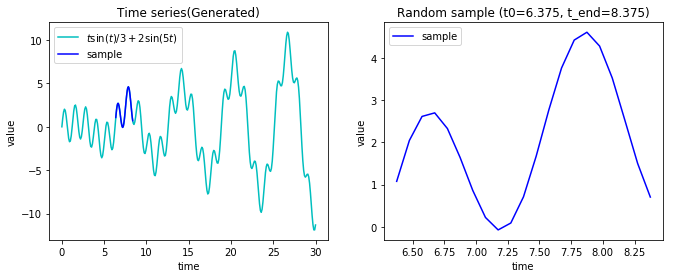

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.title('Time series(Generated)')
plt.plot(t, sequence, 'c', label=r'$t\sin(t)/3 + 2\sin(5t)$')
plt.plot(ts, sample, 'b', label='sample')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()

plt.subplot(122)
plt.title('Random sample (t0={:3.3f}, t_end={:3.3f})'.format(ts[0], ts[-1]))
plt.plot(ts, sample, 'b', label='sample')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()

plt.show()

In [4]:
import tensorflow as tf

n_steps = 20
n_features = 1
n_neurons = 100
n_outputs = 1

# Each sample sequence has 20 sample values.
X = tf.placeholder(tf.float32, [None, n_steps, n_features])
y = tf.placeholder(tf.float32, [None, n_steps, n_features])

In [5]:
lr = learning_rate = 1e-3

cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# Each step outputs [batch_size, n_neurons] tensor.
# Stacked output has a shape as [batch_size*n_steps, n_neurons]
stacked_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
# Densely connected layer outputs [batch_size*n_steps, n_outputs].
# It maps multiple outputs of the each cells to the regression output.
dense_outputs = tf.layers.dense(stacked_outputs, n_outputs)
# Unstacking to [batch_size, n_steps, n_outputs]
outputs = tf.reshape(dense_outputs, [-1, n_steps, n_outputs])

# Calculate mean square errors
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
training_op = optimizer.minimize(loss)

In [6]:
init = tf.global_variables_initializer()

batch_size = 50
batch_generator = next_batch(batch_size,
                             n_steps, resolution, t_min, t_max)

n_epochs = 1500

saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        X_batch, y_batch = batch_generator()
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print('epoch={}, MSE={:3.5f}'.format(epoch, mse))
    save_path = saver.save(sess, './time_series_regression_model.ckpt')
    print('model saved in \'{}\''.format(save_path))

epoch=0, MSE=17.39729
epoch=100, MSE=1.13543
epoch=200, MSE=0.52102
epoch=300, MSE=0.28629
epoch=400, MSE=0.20750
epoch=500, MSE=0.09853
epoch=600, MSE=0.04857
epoch=700, MSE=0.05730
epoch=800, MSE=0.04778
epoch=900, MSE=0.04586
epoch=1000, MSE=0.05195
epoch=1100, MSE=0.04756
epoch=1200, MSE=0.04392
epoch=1300, MSE=0.03888
epoch=1400, MSE=0.03818
model saved in './time_series_regression_model.ckpt'


In [8]:
with tf.Session() as sess:
    saver.restore(sess, './time_series_regression_model.ckpt')
    X_new = time_series(np.array(ts[:-1].reshape(-1, n_steps, n_features)))
    y_pred = outputs.eval(feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./time_series_regression_model.ckpt


[]

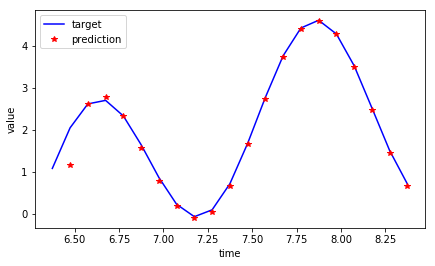

In [9]:
plt.figure(figsize=(7,4))
plt.plot(ts, sample, 'b', label='target')
plt.plot(ts[1:], y_pred.ravel(), 'r*', label='prediction')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.plot()

In [10]:
with tf.Session() as sess:
    saver.restore(sess, './time_series_regression_model.ckpt')
    
    n_iteration = len(t) - n_steps

    # With zero initial values
    seq1 = [0.0] * n_steps
    for iteration in range(n_iteration):
        X_batch = np.array(seq1[-n_steps:]).reshape(-1, n_steps, n_features)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        seq1.append(y_pred[0, -1, 0])

    # With random sample
    ts_seq_2, seq2 = sample_generator()
    seq2 = seq2[:-1].tolist()
    for iteration in range(n_iteration):
        X_batch = np.array(seq2[-n_steps:]).reshape(-1, n_steps, n_features)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        seq2.append(y_pred[0, -1, 0])

    # With original initial values
    seq3 = sequence[:n_steps].tolist()
    for iteration in range(n_iteration):
        X_batch = np.array(seq3[-n_steps:]).reshape(-1, n_steps, n_features)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        seq3.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./time_series_regression_model.ckpt


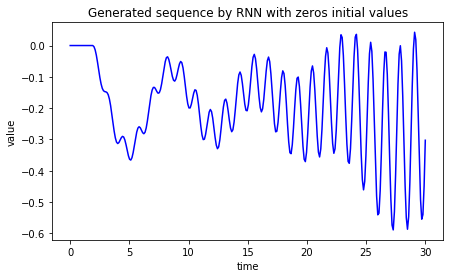

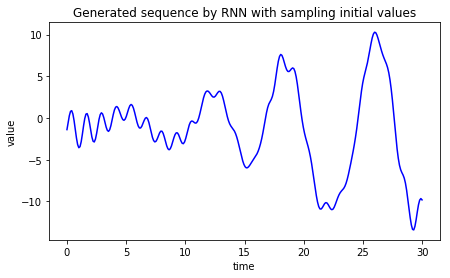

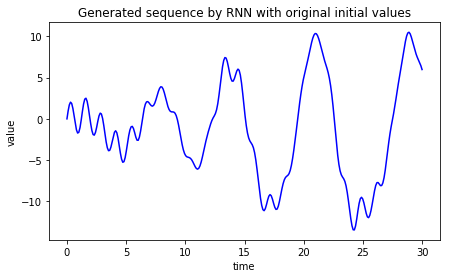

In [11]:
plt.figure(figsize=(7,4))
plt.title('Generated sequence by RNN with zeros initial values')
plt.plot(t, seq1, 'b')
plt.xlabel('time')
plt.ylabel('value')
plt.show()

plt.figure(figsize=(7,4))
plt.title('Generated sequence by RNN with sampling initial values')
plt.plot(t, seq2, 'b')
plt.xlabel('time')
plt.ylabel('value')
plt.show()

plt.figure(figsize=(7,4))
plt.title('Generated sequence by RNN with original initial values')
plt.plot(t, seq3, 'b')
plt.xlabel('time')
plt.ylabel('value')
plt.show()